# Cityscapes segmentation plots

Please note that we do not perform hyperparameter optimization in this notebook for the logit normalization.

Update the following variables with values corresponding to your own experiments:

In [1]:
# Paths
MODEL_CE_PATH = "../experiments/segmentation/logs/deeplab/version_0/checkpoints/last.ckpt"
MODEL_LS_PATH = "../experiments/segmentation/logs/deeplab_ls/version_0/checkpoints/last.ckpt"

# Choose your device
DEVICE = "cuda:0"  # or "cpu"

# Whether to save the image or not
SAVE_IMG = False

Prepare the datamodule and disable gradients:

In [2]:
import torch
from torch_uncertainty.datamodules.segmentation import CityscapesDataModule

# Disable gradients globally
torch.set_grad_enabled(False)

dm = CityscapesDataModule(root="../experiments/segmentation/data/Cityscapes", batch_size=12, num_workers=12)
dm.prepare_data()
dm.setup("test")

/home/soumik/miniconda3/envs/tu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instantiate the models in memory, the loss will not be used and is just given to instantiate the routine correctly.

In [3]:
from torch_uncertainty.models.segmentation.deeplab import deep_lab_v3_resnet101
from torch_uncertainty.routines import SegmentationRoutine

model = deep_lab_v3_resnet101(19, "v3+", pretrained_backbone=False)
model = model.to(DEVICE)
routine = SegmentationRoutine.load_from_checkpoint(MODEL_CE_PATH, model=model, loss="torch.nn.CrossEntropyLoss")
routine.model = routine.model.to(DEVICE)
routine.eval()

model_ls = deep_lab_v3_resnet101(19, "v3+", pretrained_backbone=False)
model_ls = model_ls.to(DEVICE)
ls_routine = SegmentationRoutine.load_from_checkpoint(MODEL_LS_PATH, model=model_ls, loss="torch.nn.CrossEntropyLoss")
ls_routine.model = ls_routine.model.to(DEVICE)
ls_routine.eval();

Define a function to randomly subsample pixels to reduce the time/memory consumption of the plots 

In [4]:
metric_subsampling_rate = 0.01

def subsample(pred: torch.Tensor, target: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Select a random sample of the data to compute the loss/plots onto.

    Args:
        pred (Tensor): the prediction tensor.
        target (Tensor): the target tensor.

    Returns:
        Tuple[Tensor, Tensor]: the subsampled prediction and target tensors.

    Note:
        Taken from TU.
    """
    total_size = target.size(0)
    num_samples = max(1, 5000)
    indices = torch.randperm(total_size, device=pred.device)[:num_samples]
    return pred[indices, :], target[indices], indices

Compute the logits with the CE-based and LS-based models. This may take a few minutes.

In [5]:
from torch_uncertainty_ls.utils import norm_logits
from einops import rearrange
from tqdm.auto import tqdm

kept_scores = []
kept_scores_ls = []
normalized_scores = []
normalized_scores_ls = []
correct_samples = []
correct_samples_ls = []

with torch.amp.autocast("cuda"):
    for x, y in tqdm(dm.test_dataloader()[0]):
        x = x.to(DEVICE)
        score = rearrange(routine(x).squeeze(-1), "b c h w -> (b h w) c")
        score_ls = rearrange(ls_routine(x).squeeze(-1), "b c h w -> (b h w) c")
        y = y.flatten()

        # delete pixels without (reliable) target
        mask = y != 255
        y = y[mask].cpu()
        kept_score, kept_targets, indices = subsample(score[mask, :].cpu(), y)
        kept_score_ls = score_ls[mask, :].cpu()[indices, :]

        predicted = kept_score.argmax(1)
        predicted_ls = kept_score_ls.argmax(1)

        # no softmax on the normalized logits
        # Also note the non-optimized hyperparams and the inner conversion to double
        normalized_scores.append(norm_logits(kept_score.T, p=8, add_unit=0).T)
        normalized_scores_ls.append(norm_logits(kept_score_ls.T, p=8, add_unit=0).T)

        kept_scores.append(kept_score.softmax(-1))
        kept_scores_ls.append(kept_score_ls.softmax(-1))

        correct = predicted == kept_targets
        correct_ls = predicted_ls == kept_targets
        
        correct_samples.append(correct)
        correct_samples_ls.append(correct_ls)

scores = torch.cat(kept_scores)
scores_ls = torch.cat(kept_scores_ls)
normalized_scores = torch.cat(normalized_scores)
normalized_scores_ls = torch.cat(normalized_scores_ls)
correct_samples = torch.cat(correct_samples)
correct_samples_ls = torch.cat(correct_samples_ls)

100%|██████████| 42/42 [03:24<00:00,  4.86s/it]


In [6]:
from torch_uncertainty_ls.utils import risk_coverage_curve

ce_risk, ce_cov, thresholds = risk_coverage_curve(correct_samples, scores.max(1).values)
ls_risk, ls_cov, thresholds_ls = risk_coverage_curve(correct_samples_ls, scores_ls.max(1).values)

Create the plots

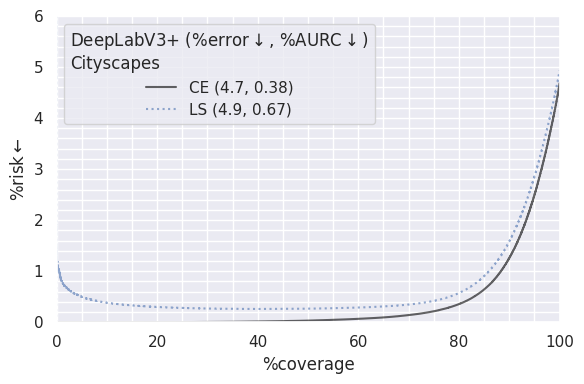

In [7]:
import matplotlib.pyplot as plt
import seaborn

# set the style
seaborn.set_theme()

# Compute and show the risk-coverage curves
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(
    ce_cov * 100,
    ce_risk * 100,
    label=f"CE ({ce_risk[-1]*100:.1f}, {torch.trapz(ce_risk, ce_cov).item()*100:.2f})",
    alpha=0.6,
    color="black",
)
ax.plot(
    ls_cov * 100,
    ls_risk * 100,
    label=f"LS ({ls_risk[-1]*100:.1f}, {torch.trapz(ls_risk, ls_cov).item()*100:.2f})",
    alpha=0.6,
    linestyle="dotted",
)
ax.set_xlabel("%coverage")
ax.set_ylabel("%risk$\leftarrow$")
ax.legend(title="DeepLabV3+ (%error$\downarrow$, %AURC$\downarrow$)\nCityscapes", loc="upper left")
ax.grid(visible=True, which="both")
ax.set_xlim(0, 100)
ax.set_ylim(0, 6)
ax.minorticks_on()
fig.tight_layout()

if SAVE_IMG:
    plt.savefig("cityscapes.pdf", dpi=300)

plt.show();

Plot of the values obtained with normalized logits

In [8]:
from torch_uncertainty_ls.utils import risk_coverage_curve

norm_ce_risk, norm_ce_cov, norm_thresholds = risk_coverage_curve(correct_samples, normalized_scores.max(1).values)
norm_ls_risk, norm_ls_cov, norm_thresholds_ls = risk_coverage_curve(correct_samples_ls, normalized_scores_ls.max(1).values)

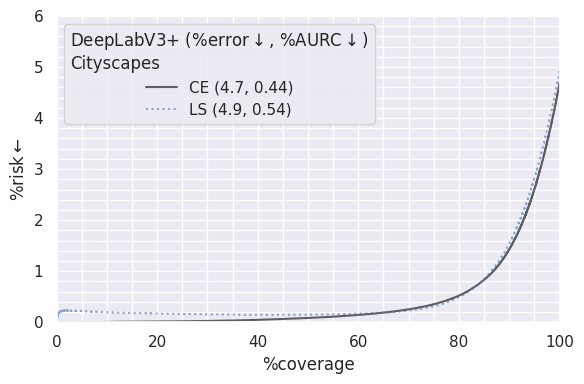

In [9]:
import matplotlib.pyplot as plt
import seaborn

# set the style
seaborn.set_theme()

# Compute and show the risk-coverage curves
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(
    norm_ce_cov * 100,
    norm_ce_risk * 100,
    label=f"CE ({ce_risk[-1]*100:.1f}, {torch.trapz(norm_ce_risk, norm_ce_cov).item()*100:.2f})",
    alpha=0.6,
    color="black",
)
ax.plot(
    norm_ls_cov * 100,
    norm_ls_risk * 100,
    label=f"LS ({ls_risk[-1]*100:.1f}, {torch.trapz(norm_ls_risk, norm_ls_cov).item()*100:.2f})",
    alpha=0.6,
    linestyle="dotted",
)
ax.set_xlabel("%coverage")
ax.set_ylabel("%risk$\leftarrow$")
ax.legend(title="DeepLabV3+ (%error$\downarrow$, %AURC$\downarrow$)\nCityscapes", loc="upper left")
ax.grid(visible=True, which="both")
ax.set_xlim(0, 100)
ax.set_ylim(0, 6)
ax.minorticks_on()
fig.tight_layout()

if SAVE_IMG:
    plt.savefig("cityscapes_norm.pdf", dpi=300)

plt.show();